In [ ]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # if needed for visualization
from scipy.stats import ks_2samp

# Model selection, preprocessing, and evaluation
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Hyperparameter optimization
import optuna


First few rows:
   label        f0        f1        f2        f3        f4        f5  \
0    1.0  0.869293 -0.635082  0.225690  0.327470 -0.689993  0.754202   
1    1.0  0.907542  0.329147  0.359412  1.497970 -0.313010  1.095531   
2    1.0  0.798835  1.470639 -1.635975  0.453773  0.425629  1.104875   
3    0.0  1.344385 -0.876626  0.935913  1.992050  0.882454  1.786066   
4    1.0  1.105009  0.321356  1.522401  0.882808 -1.205349  0.681466   

         f6        f7        f8  ...       f18       f19       f20       f21  \
0 -0.248573 -1.092064  0.000000  ... -0.010455 -0.045767  3.101961  1.353760   
1 -0.557525 -1.588230  2.173076  ... -1.138930 -0.000819  0.000000  0.302220   
2  1.282322  1.381664  0.000000  ...  1.128848  0.900461  0.000000  0.909753   
3 -1.646778 -0.942383  0.000000  ... -0.678379 -1.360356  0.000000  0.946652   
4 -1.070464 -0.921871  0.000000  ... -0.373566  0.113041  0.000000  0.755856   

        f22       f23       f24       f25       f26       f27  
0  0.9

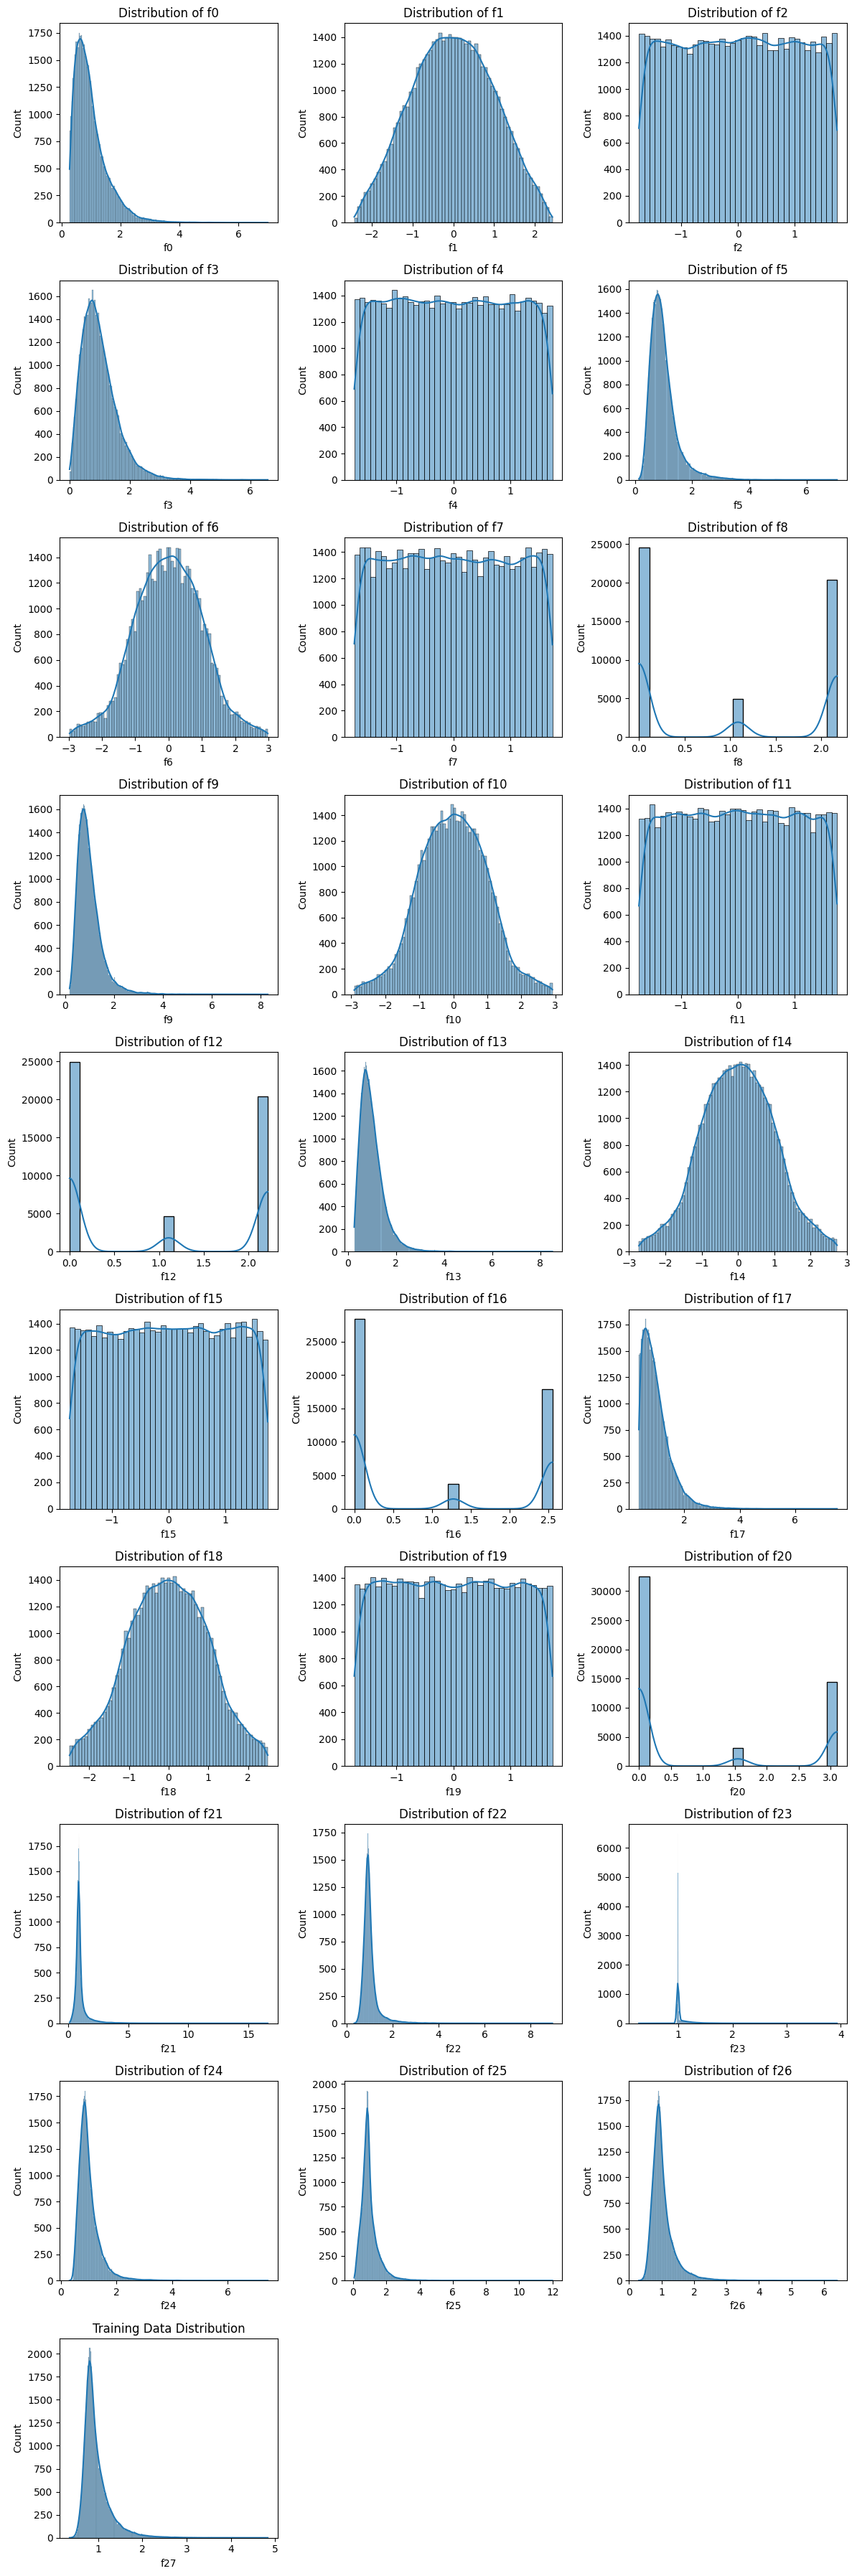

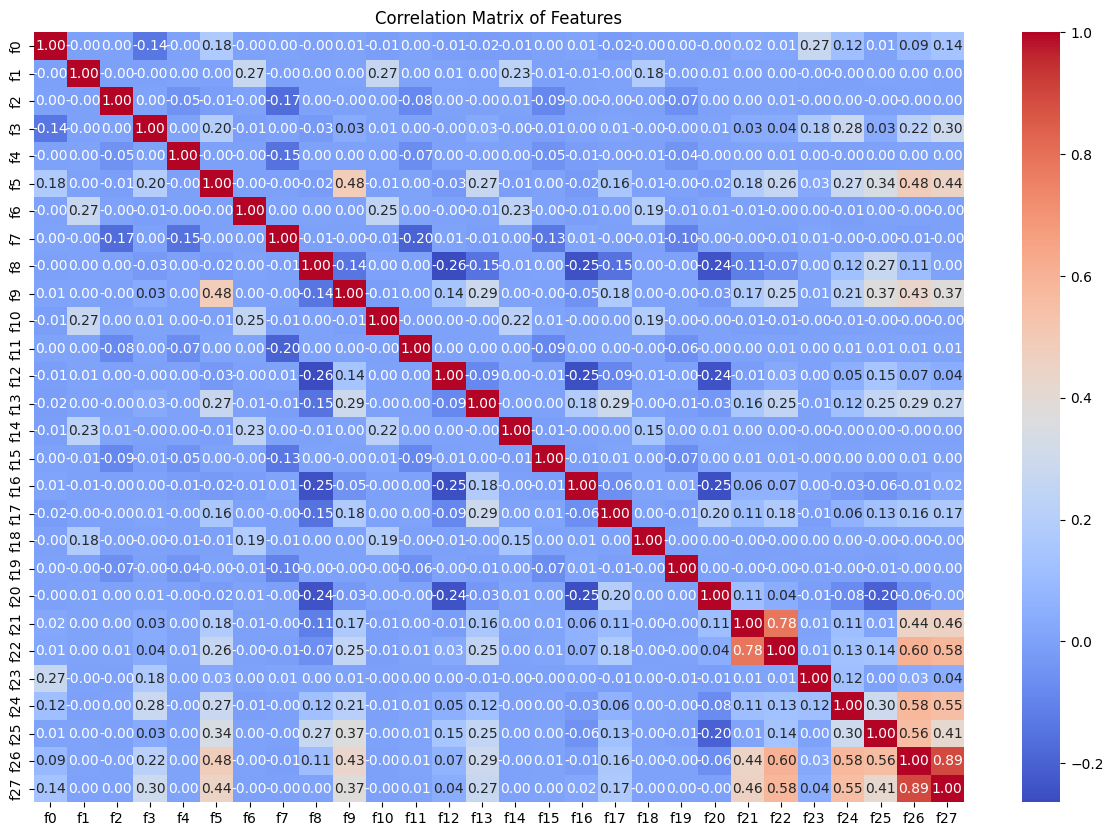

In [ ]:
# Load the dataset
train = pd.read_csv("./data/train.csv")

# Display the first few rows
print("First few rows:")
print(train.head())

# Summary statistics for each column
print("\nSummary Statistics:")
print(train.describe())

# Check for missing values
print("\nMissing Values per Column:")
print(train.isnull().sum())

# Compute skewness for each feature (excluding the label)
features = train.columns[1:]
skewness = train[features].skew()
print("\nSkewness of features:")
print(skewness)

# Plot histograms for feature data distributions
plt.figure(figsize=(12, 36))
for i, feature in enumerate(features[0:]): 
    plt.subplot(10, 3, i+1)
    sns.histplot(train[feature], kde=True)
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.title("Training Data Distribution")
plt.show()

# Plot a correlation matrix heatmap for the features
plt.figure(figsize=(15, 10))
corr = train[features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Features")
plt.show()


First few rows:
         f0        f1        f2        f3        f4        f5        f6  \
0  0.717945 -1.166869 -1.713655  0.842482  0.738519  0.795151  1.440759   
1  0.924379 -0.015638  0.213483  0.335945  1.626573  0.508695 -1.577462   
2  1.473040 -0.355553 -0.290433  0.627585 -1.292596  0.916988  1.264498   
3  0.908091  0.421674  1.426965  0.776275 -1.000624  1.096080 -0.199062   
4  1.639761  0.916450 -0.925197  0.695436  0.896574  0.545796  0.582230   

         f7        f8        f9  ...       f18       f19  f20       f21  \
0 -0.523826  0.000000  1.542066  ...  0.415118 -1.198322  0.0  0.850173   
1 -1.041061  0.000000  0.598797  ...  1.168823  0.481502  0.0  0.824786   
2 -0.577604  0.000000  1.781031  ... -0.827454 -0.714439  0.0  1.956970   
3 -0.078109  2.173076  0.512931  ... -0.626744  0.671282  0.0  0.512490   
4  0.878846  2.173076  0.284290  ... -1.663609  1.237293  0.0  1.551649   

        f22       f23       f24       f25       f26       f27  
0  0.902519  0.985

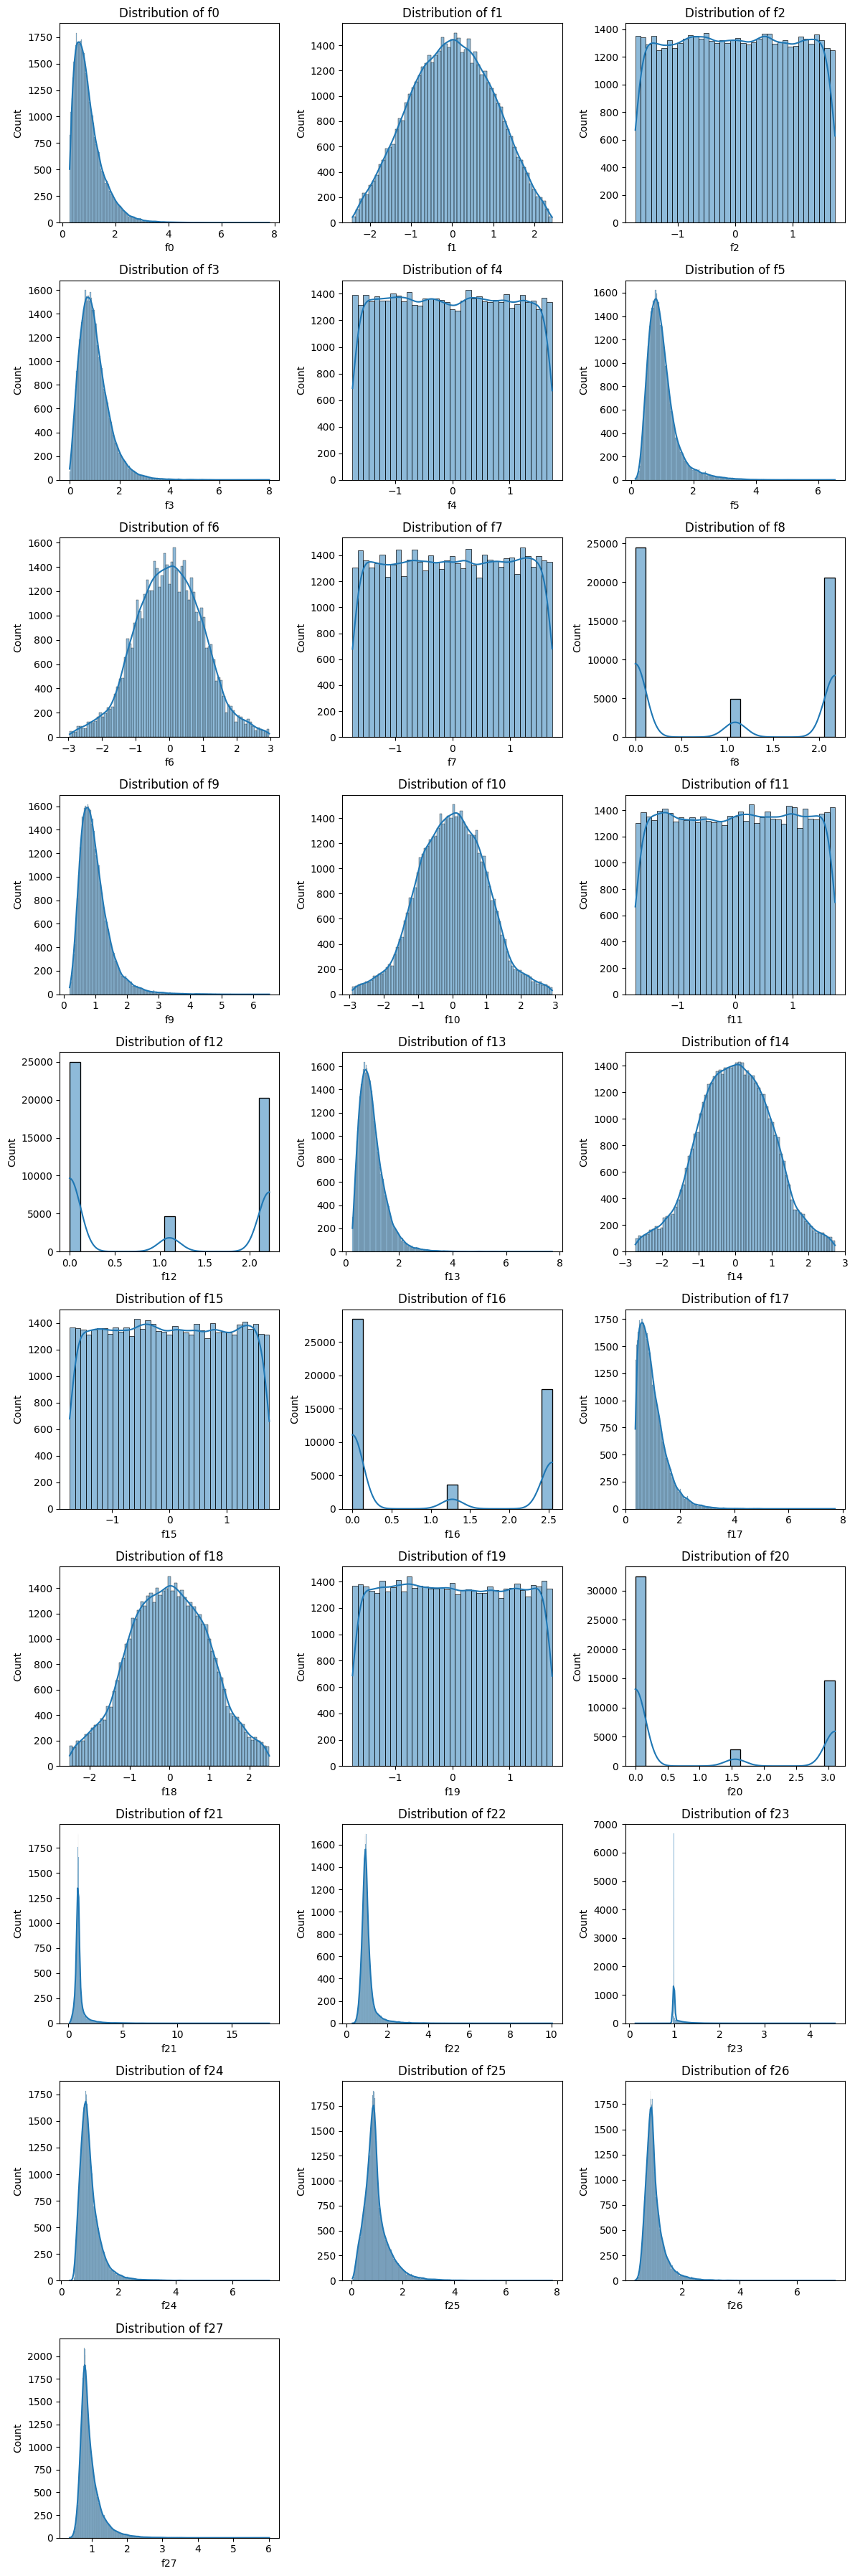

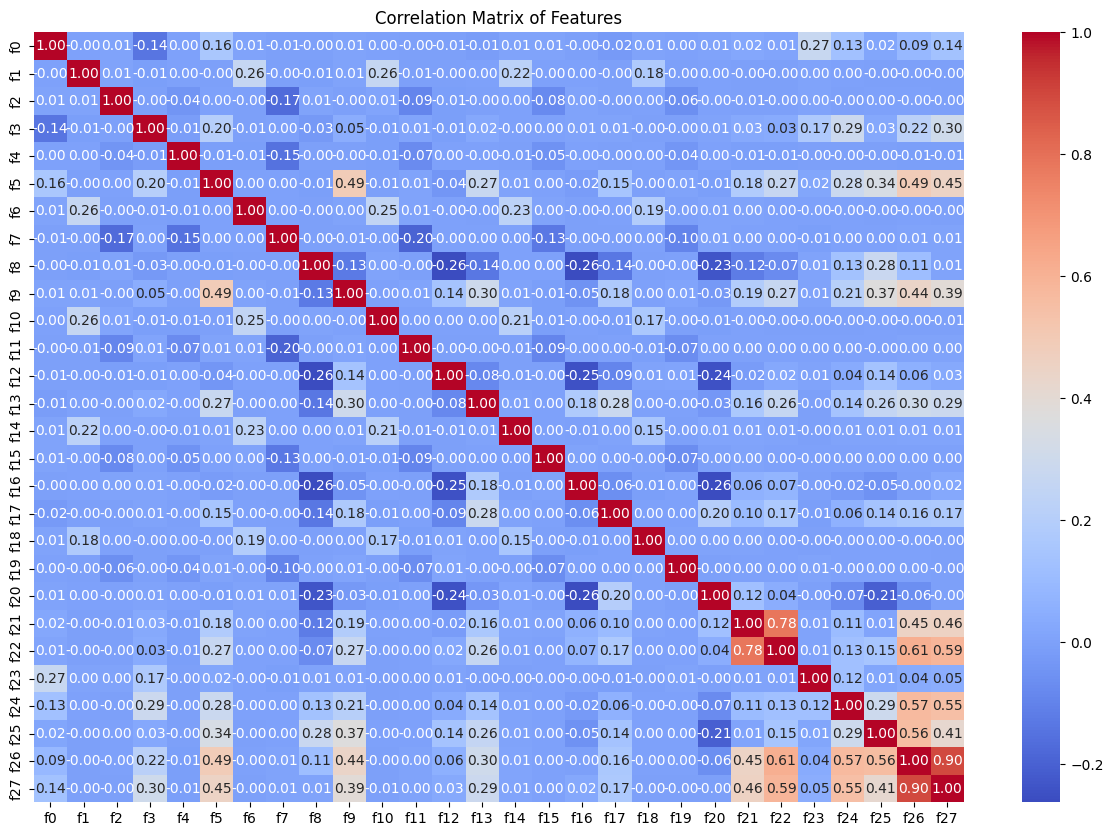

In [ ]:
# Load the dataset
test = pd.read_csv("./data/test.csv")

# Display the first few rows
print("First few rows:")
print(test.head())

# Summary statistics for each column
print("\nSummary Statistics:")
print(test.describe())

# Check for missing values
print("\nMissing Values per Column:")
print(test.isnull().sum())

# Compute skewness for each feature 
features = test.columns[0:] 
skewness = test[features].skew()
print("\nSkewness of features:")
print(skewness)

# Plot histograms for feature data distributions
plt.figure(figsize=(12, 36))
for i, feature in enumerate(features[0:]): 
    plt.subplot(10, 3, i+1)
    sns.histplot(test[feature], kde=True)
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

# Plot a correlation matrix heatmap for the features
plt.figure(figsize=(15, 10))
corr = test[features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Features")
plt.show()


In [ ]:

# Load data
X = train.drop(columns=["label"])
y = train["label"]

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# Specify highly skewed features
skewed_features = ['f0', 'f3', 'f5', 'f9', 'f13', 'f17', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27']
other_features = [col for col in X.columns if col not in skewed_features]

# Pipeline for highly skewed features: Impute and apply log1p
skewed_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('log', FunctionTransformer(np.log1p))
])

# Pipeline for other features: Only impute (no transformation)
others_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Combine transformations using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('skewed', skewed_pipeline, skewed_features),
    ('others', others_pipeline, other_features)
])

# Add scaling for consistency (applied to all features)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler())
])

# Transform the data
X_train_processed = pipeline.fit_transform(X_train)
X_val_processed = pipeline.transform(X_val)
test_processed = pipeline.transform(test)

print("Original X_train shape:", X_train.shape)
print("Transformed X_train_processed shape:", X_train_processed.shape)


Original X_train shape: (40000, 28)
Transformed X_train_processed shape: (40000, 28)


In [ ]:
# Optuna hyperparamter for Random Forest
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 480, 520),
        'max_depth': trial.suggest_int('max_depth', 16, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 4, 7),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': 'sqrt',
        'random_state': 42
    }
    
    model = RandomForestClassifier(**params, n_jobs=-1)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc = cross_val_score(model, X_train_processed, y_train, scoring='roc_auc', cv=cv, n_jobs=-1).mean()
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
print("  AUROC: ", study.best_trial.value)
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")


[I 2025-03-11 04:18:34,303] A new study created in memory with name: no-name-7e975546-aa08-4156-ac4b-bf93e298cbf3
[I 2025-03-11 04:25:20,954] Trial 0 finished with value: 0.790960957120895 and parameters: {'n_estimators': 509, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.790960957120895.
[I 2025-03-11 04:31:12,873] Trial 1 finished with value: 0.7897078839781208 and parameters: {'n_estimators': 494, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.790960957120895.
[I 2025-03-11 04:38:05,477] Trial 2 finished with value: 0.7906222283815724 and parameters: {'n_estimators': 502, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.790960957120895.
[I 2025-03-11 04:44:08,216] Trial 3 finished with value: 0.7907983106795458 and parameters: {'n_estimators': 482, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.

Best trial:
  AUROC:  0.7915014789267897
    n_estimators: 498
    max_depth: 19
    min_samples_split: 5
    min_samples_leaf: 3


In [6]:
# Train Random Forest on the enhanced features
rf = RandomForestClassifier(n_estimators=498, max_depth=19, min_samples_leaf = 3,  min_samples_split =  5, random_state=42, n_jobs=-1)
rf.fit(X_train_processed, y_train)

# Evaluate AUROC on the validation set
rf_val_pred = rf.predict_proba(X_val_processed)[:, 1]
rf_auc = roc_auc_score(y_val, rf_val_pred)
print(f"Random Forest Validation AUROC : {rf_auc:.4f}")



Random Forest Validation AUROC : 0.7912


In [ ]:
# Optuna hyperparamter for XGBoost
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 450, 520),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.02, log=True),
        'max_depth': trial.suggest_int('max_depth', 9, 11),
        'subsample': trial.suggest_float('subsample', 0.63, 0.67),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.84, 0.86),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 10.0),
        'eval_metric': 'auc'
        
    }
    model = xgb.XGBClassifier(**params)  
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    auc = cross_val_score(model, X_train_processed, y_train, scoring='roc_auc', cv=cv, n_jobs=-1).mean()
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")


[I 2025-03-10 04:08:43,092] A new study created in memory with name: no-name-6db837e1-b69b-4b40-9e59-b78cbb92954f
[I 2025-03-10 04:09:36,946] Trial 0 finished with value: 0.7990280635067619 and parameters: {'n_estimators': 465, 'learning_rate': 0.01186207596460321, 'max_depth': 10, 'subsample': 0.643030195795321, 'colsample_bytree': 0.8466383045422217, 'reg_alpha': 0.25713198371661206, 'reg_lambda': 9.12025202332343}. Best is trial 0 with value: 0.7990280635067619.
[I 2025-03-10 04:10:33,076] Trial 1 finished with value: 0.8001157977047454 and parameters: {'n_estimators': 512, 'learning_rate': 0.01642879565781688, 'max_depth': 10, 'subsample': 0.6353869140947602, 'colsample_bytree': 0.8570738488035455, 'reg_alpha': 0.6670029265108329, 'reg_lambda': 6.4215489554925735}. Best is trial 1 with value: 0.8001157977047454.
[I 2025-03-10 04:11:10,149] Trial 2 finished with value: 0.79934944652797 and parameters: {'n_estimators': 461, 'learning_rate': 0.013636515416493999, 'max_depth': 9, 'subs

Best trial:
  Value:  0.8010887904013071
  Params: 
    n_estimators: 520
    learning_rate: 0.014257342859086941
    max_depth: 10
    subsample: 0.6564469040063404
    colsample_bytree: 0.8573289063668115
    reg_alpha: 0.8469390678713753
    reg_lambda: 3.0239557363060583


In [16]:
# Train Random Forest on the enhanced features
xgb_model = xgb.XGBClassifier(n_estimators=520, learning_rate= 0.014257342859086941, max_depth=10, eval_metric='auc', subsample = 0.6564469040063404, colsample_bytree =  0.8573289063668115, reg_alpha = 0.8469390678713753, reg_lambda = 3.0239557363060583  )
xgb_model.fit(X_train_processed, y_train)

# Evaluate AUROC on the validation set
xgb_val_pred = xgb_model.predict_proba(X_val_processed)[:, 1]
xgb_auc = roc_auc_score(y_val, xgb_val_pred)
print(f"XGBoost Validation AUROC: {xgb_auc:.4f}")


XGBoost Validation AUROC: 0.8050


In [ ]:
# Optuna hyperparamter for LightGBM
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 350, 450),
        'learning_rate': trial.suggest_float('learning_rate', 0.015, 0.025, log=True),
        'max_depth': trial.suggest_int('max_depth', 8, 10),
        'num_leaves': trial.suggest_int('num_leaves', 120, 140),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 50, 70),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.80, 0.87),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.65, 0.75),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 3),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 10.0),
        'random_state': 42,
        'eval_metric': 'auc'
    }
     
    model = lgb.LGBMClassifier(**params)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    auc = cross_val_score(model, X_train_processed, y_train, scoring='roc_auc', cv=cv, n_jobs=-1).mean()
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")


[I 2025-03-10 03:20:02,301] A new study created in memory with name: no-name-35a73635-333d-4101-8b75-348e22377bde
[I 2025-03-10 03:20:18,472] Trial 0 finished with value: 0.7991773654183314 and parameters: {'n_estimators': 412, 'learning_rate': 0.02008684843661499, 'max_depth': 10, 'num_leaves': 129, 'min_data_in_leaf': 69, 'feature_fraction': 0.841702285672245, 'bagging_fraction': 0.7391509349790422, 'bagging_freq': 2, 'reg_alpha': 0.7095482291992601, 'reg_lambda': 2.2882640831013363}. Best is trial 0 with value: 0.7991773654183314.
[I 2025-03-10 03:20:30,156] Trial 1 finished with value: 0.7980839621014311 and parameters: {'n_estimators': 382, 'learning_rate': 0.015246792558741966, 'max_depth': 8, 'num_leaves': 122, 'min_data_in_leaf': 67, 'feature_fraction': 0.8677189642345693, 'bagging_fraction': 0.7060565443078471, 'bagging_freq': 3, 'reg_alpha': 0.03160065975871018, 'reg_lambda': 4.662063371071478}. Best is trial 0 with value: 0.7991773654183314.
[I 2025-03-10 03:20:43,713] Trial

Best trial:
  Value:  0.8005577921261681
  Params: 
    n_estimators: 442
    learning_rate: 0.024827472692276954
    max_depth: 10
    num_leaves: 137
    min_data_in_leaf: 62
    feature_fraction: 0.8106994770919714
    bagging_fraction: 0.7405992794809058
    bagging_freq: 1
    reg_alpha: 0.48817438960735265
    reg_lambda: 7.85355345315286


In [ ]:
# Train LightGBM on the enhanced features
lgb_model = lgb.LGBMClassifier(n_estimators=442, learning_rate= 0.024827472692276954, max_depth=10, num_leaves = 137, min_data_in_leaf = 62, feature_fraction = 0.8106994770919714, bagging_fraction = 0.7405992794809058, bagging_freq = 1, reg_alpha = 0.48817438960735265, reg_lambda = 7.85355345315286, random_state=42, verbose = -1)
lgb_model.fit(X_train_processed, y_train)

# Evaluate AUROC on the validation set
lgb_val_pred = lgb_model.predict_proba(X_val_processed)[:, 1]
lgb_auc = roc_auc_score(y_val, lgb_val_pred)
print(f"LightGBM Validation AUROC: {lgb_auc:.4f}")



LightGBM Validation AUROC: 0.8039


In [ ]:
# Define the objective function for Optuna
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 800, 900),
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.03, log=True),
        'depth': trial.suggest_int('depth', 7, 9),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 5, 8),
        'border_count': trial.suggest_int('border_count', 80, 120),
        'random_strength': trial.suggest_float('random_strength', 0.0, 2.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 2.0),
        'random_seed': 42,
        'eval_metric': 'AUC',
        'verbose': False
    }
    
    
    # Create the CatBoostClassifier with the suggested parameters
    model = CatBoostClassifier(**params)
    
    # Set up stratified cross-validation
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # Compute the mean AUROC over the folds
    auc = cross_val_score(model, X_train_processed, y_train, scoring='roc_auc', cv=cv, n_jobs=-1).mean()
    return auc

# Create the study and run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

# Print out the best trial's performance and hyperparameters
print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")


[I 2025-03-10 07:32:16,711] A new study created in memory with name: no-name-2fc0e83e-6ab9-4143-ab79-ba39ea54513d
[I 2025-03-10 07:33:31,814] Trial 0 finished with value: 0.7983916771710389 and parameters: {'iterations': 893, 'learning_rate': 0.02128397135627745, 'depth': 9, 'l2_leaf_reg': 6.713302138418187, 'border_count': 100, 'random_strength': 1.4833220984478062, 'bagging_temperature': 0.3807102365928965, 'scale_pos_weight': 0.6306379388935739}. Best is trial 0 with value: 0.7983916771710389.
[I 2025-03-10 07:34:12,077] Trial 1 finished with value: 0.7977645413091805 and parameters: {'iterations': 897, 'learning_rate': 0.02393396913038432, 'depth': 7, 'l2_leaf_reg': 6.693099994568199, 'border_count': 96, 'random_strength': 1.1274963985275466, 'bagging_temperature': 0.6698604886875371, 'scale_pos_weight': 1.6233118122662429}. Best is trial 0 with value: 0.7983916771710389.
[I 2025-03-10 07:35:02,136] Trial 2 finished with value: 0.7995727451836675 and parameters: {'iterations': 859,

Best trial:
  Value:  0.7998987678727261
  Params: 
    iterations: 861
    learning_rate: 0.02583359028318419
    depth: 8
    l2_leaf_reg: 7.351885018701983
    border_count: 117
    random_strength: 0.5111668410737095
    bagging_temperature: 0.3950913454952565
    scale_pos_weight: 0.6759132046640219


In [ ]:
# Train CatBoost on the enhanced features
cat_model = CatBoostClassifier(iterations=861, learning_rate=0.02583359028318419, depth=8, eval_metric='AUC', random_seed=42, l2_leaf_reg =7.351885018701983, border_count = 117, random_strength =  0.5111668410737095, bagging_temperature = 0.3950913454952565, scale_pos_weight = 0.6759132046640219, verbose = 0)
cat_model.fit(X_train_processed, y_train, eval_set=(X_val_processed, y_val), use_best_model=True)

# Evaluate AUROC on the validation set
y_val_pred = cat_model.predict_proba(X_val_processed)[:, 1]
cat_auc = roc_auc_score(y_val, y_val_pred)
print(f"CatBoost Validation AUROC: {cat_auc:.4f}")


TBB Warning: The number of workers is currently limited to 0. The request for 47 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



CatBoost Validation AUROC: 0.8024


In [ ]:
# Define base models
base_models = [
    ('rf', rf),  # Random Forest
    ('xgb', xgb_model),  # XGBoost
    ('lgb', lgb_model),   # LightGBM
    ('cat', cat_model)

]


meta_nn = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    alpha = 0.001,
    activation='relu',
    max_iter=500,
    early_stopping=True,      
    validation_fraction=0.2,   
    n_iter_no_change=10,        
    random_state=42,
    verbose= True)

# Meta-learner (Final classifier that learns from base models' predictions)
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator= meta_nn,
    cv=5,
    n_jobs=-1,
    passthrough = False

)
# Train the stacked model
stacking_clf.fit(X_train_processed, y_train)
# Predict on validation set
stacked_val_pred = stacking_clf.predict_proba(X_val_processed)[:, 1]
stacked_auc = roc_auc_score(y_val, stacked_val_pred)
print(f"Stacked Model Validation AUROC: {stacked_auc:.4f}")




Iteration 1, loss = 0.58023464
Validation score: 0.720125
Iteration 2, loss = 0.53948274
Validation score: 0.719500
Iteration 3, loss = 0.53849587
Validation score: 0.716375
Iteration 4, loss = 0.53834088
Validation score: 0.718000
Iteration 5, loss = 0.53800920
Validation score: 0.718625
Iteration 6, loss = 0.53790776
Validation score: 0.718500
Iteration 7, loss = 0.53819309
Validation score: 0.719625
Iteration 8, loss = 0.53773845
Validation score: 0.718125
Iteration 9, loss = 0.53768187
Validation score: 0.719625
Iteration 10, loss = 0.53738574
Validation score: 0.718875
Iteration 11, loss = 0.53710660
Validation score: 0.716750
Iteration 12, loss = 0.53711810
Validation score: 0.718000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Stacked Model Validation AUROC: 0.8059


In [ ]:
#Optimize final estimator MLP
param_grid = {
    'final_estimator__hidden_layer_sizes': [(50, 20), (100, 50), (50, 50)],
    'final_estimator__alpha': [0.0001, 0.001, 0.01],  # Regularization parameter
}

grid = GridSearchCV(estimator=stacking_clf, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid.fit(X_train_processed, y_train)

print("Best meta-learner parameters:", grid.best_params_)
print("Stacked Model Validation AUROC after tuning:", grid.best_score_)


Best meta-learner parameters: {'final_estimator__alpha': 0.001, 'final_estimator__hidden_layer_sizes': (100, 50)}
Stacked Model Validation AUROC after tuning: 0.8027917860882468


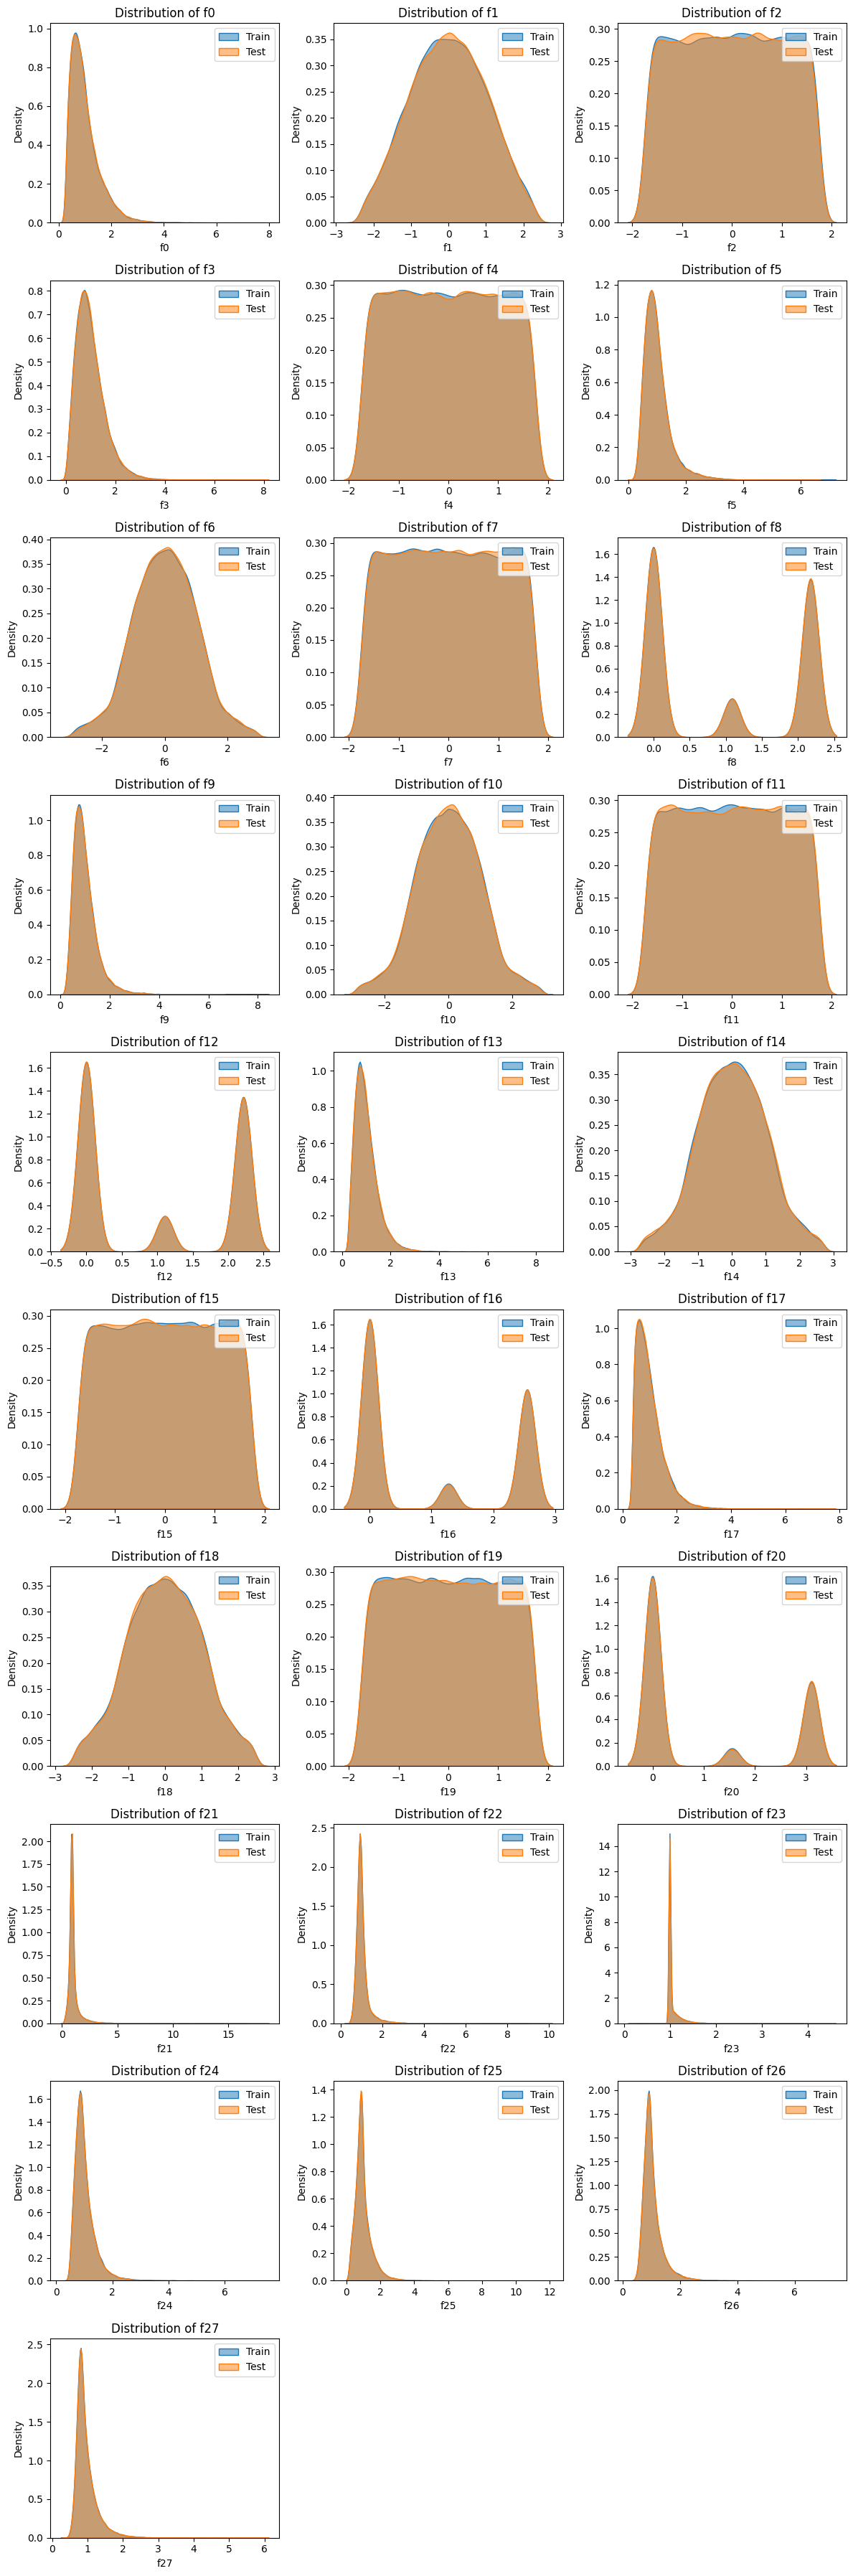

In [ ]:

#Generate Feature data distribution
features_to_check = train.columns[1:] 

plt.figure(figsize=(12, 36))
for i, feature in enumerate(features_to_check):
    plt.subplot(10, 3, i+1)
    sns.kdeplot(train[feature], label='Train', fill=True, alpha=0.5)
    sns.kdeplot(test[feature], label='Test', fill=True, alpha=0.5)
    plt.title(f'Distribution of {feature}')
    plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#Generate Kolmogorov-Smirnov 
for feature in features_to_check:
    stat, p_value = ks_2samp(train[feature], test[feature])
    print(f"Feature: {feature}, KS Statistic: {stat:.4f}, P-value: {p_value:.4f}")


Feature: f0, KS Statistic: 0.0053, P-value: 0.4821
Feature: f1, KS Statistic: 0.0082, P-value: 0.0712
Feature: f2, KS Statistic: 0.0049, P-value: 0.5945
Feature: f3, KS Statistic: 0.0062, P-value: 0.2905
Feature: f4, KS Statistic: 0.0029, P-value: 0.9830
Feature: f5, KS Statistic: 0.0040, P-value: 0.8171
Feature: f6, KS Statistic: 0.0041, P-value: 0.7882
Feature: f7, KS Statistic: 0.0054, P-value: 0.4532
Feature: f8, KS Statistic: 0.0032, P-value: 0.9593
Feature: f9, KS Statistic: 0.0043, P-value: 0.7375
Feature: f10, KS Statistic: 0.0039, P-value: 0.8400
Feature: f11, KS Statistic: 0.0058, P-value: 0.3724
Feature: f12, KS Statistic: 0.0015, P-value: 1.0000
Feature: f13, KS Statistic: 0.0045, P-value: 0.6955
Feature: f14, KS Statistic: 0.0042, P-value: 0.7732
Feature: f15, KS Statistic: 0.0048, P-value: 0.6157
Feature: f16, KS Statistic: 0.0016, P-value: 1.0000
Feature: f17, KS Statistic: 0.0064, P-value: 0.2563
Feature: f18, KS Statistic: 0.0051, P-value: 0.5219
Feature: f19, KS Stati

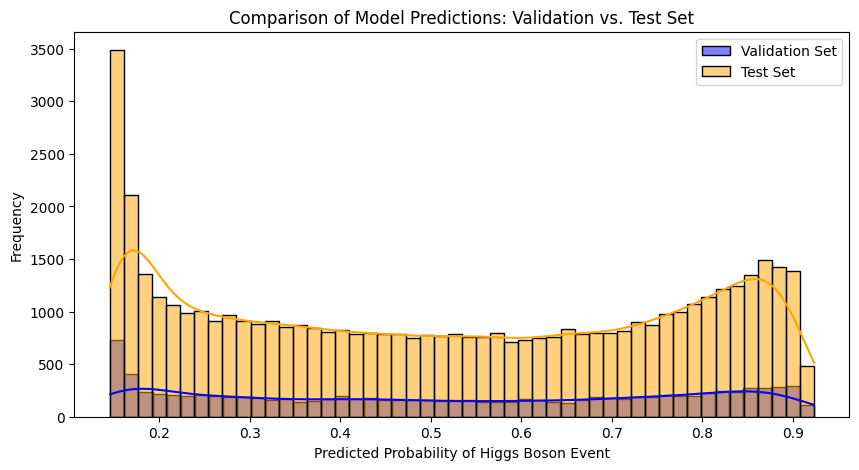

In [ ]:
# Get predicted probabilities for validation and test sets
val_predictions = stacking_clf.predict_proba(X_val_processed)[:, 1] 
test_predictions = stacking_clf.predict_proba(test_processed)[:, 1] 

# Plot predicted probabilities between Validation set and Test set
plt.figure(figsize=(10, 5))
sns.histplot(val_predictions, bins=50, kde=True, color='blue', label="Validation Set")
sns.histplot(test_predictions, bins=50, kde=True, color='orange', label="Test Set")
plt.xlabel("Predicted Probability of Higgs Boson Event")
plt.ylabel("Frequency")
plt.title("Comparison of Model Predictions: Validation vs. Test Set")
plt.legend()
plt.show()


In [17]:


#Generate submission file
y_test_pred = stacking_clf.predict_proba(test_processed)[:, 1]

n = len(test_processed)
ids = [format(i, ".18e") for i in range(n)]

submission = pd.DataFrame({
    "Id": ids,
    "Predicted": y_test_pred
})
submission.to_csv("submission.csv", index=False)

print("Submission file generated as submission.csv")


Submission file generated as submission.csv
